In [1]:
import pip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import random as rand
import copy
import time

from ucimlrepo import fetch_ucirepo

def column(X, d):
    return [row[d] for row in X]

def randindices(arr, n):
    uniqueindices=rand.sample(range(len(arr)), n)

    return uniqueindices
    
#Task 1 Part 1

# fetch dataset
wine = fetch_ucirepo(id=109)

# data (as pandas dataframes)
winefeatures = wine.data.features
#inserting bias
if winefeatures.iloc[0][0]!=1:
    winefeatures.insert(0, "Bias", [1]*len(winefeatures.index), True)
winefeaturesnp=winefeatures.to_numpy()

#Using avg, std normalization for wine features.  
MUX=[np.average(column(winefeaturesnp, d)) for d in range(len(winefeaturesnp[0]))]
SIGMAX=[np.std(column(winefeaturesnp, d)) for d in range(len(winefeaturesnp[0]))]

for d in range(len(winefeaturesnp[0])):
    for n in range(len(winefeaturesnp)):
        winefeaturesnp[n][d]=(winefeaturesnp[n][d]-MUX[d])/SIGMAX[d] if SIGMAX[d]!=0 else 0
        
winetargets = [wine.data.targets.to_numpy()[i][0] for i in range(len(wine.data.targets.to_numpy()))]

bostondb=pd.read_csv("boston.csv")
cleaneddb=bostondb.drop(bostondb.columns[11], axis=1)
#inserting bias
if cleaneddb.iloc[0][0]!=1:
    cleaneddb.insert(0, "Bias", [1]*len(cleaneddb.index), True)   
cleaneddbnp=cleaneddb.to_numpy()
MAXX=[np.max(column(cleaneddbnp, d)) for d in range(len(cleaneddbnp[0]))]

#Using max normalization for housing database.
for d in range(len(cleaneddbnp[0])):
    for n in range(len(cleaneddbnp)):
        cleaneddbnp[n][d]/=MAXX[d]

cleaneddbtargets=bostondb["MEDV"].to_numpy()
MAXY=np.max(cleaneddbtargets)
cleaneddbtargets=[cleaneddbtargets[i]/MAXY for i in range(len(cleaneddbtargets))]

C:\Users\Shiyan Liu\AppData\Local\Temp\ipykernel_24024\1181958334.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if winefeatures.iloc[0][0]!=1:
C:\Users\Shiyan Liu\AppData\Local\Temp\ipykernel_24024\1181958334.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if cleaneddb.iloc[0][0]!=1:


C:\Users\Shiyan Liu\AppData\Local\Temp\ipykernel_4804\2052729433.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ele=cleaneddb.iloc[j][i]


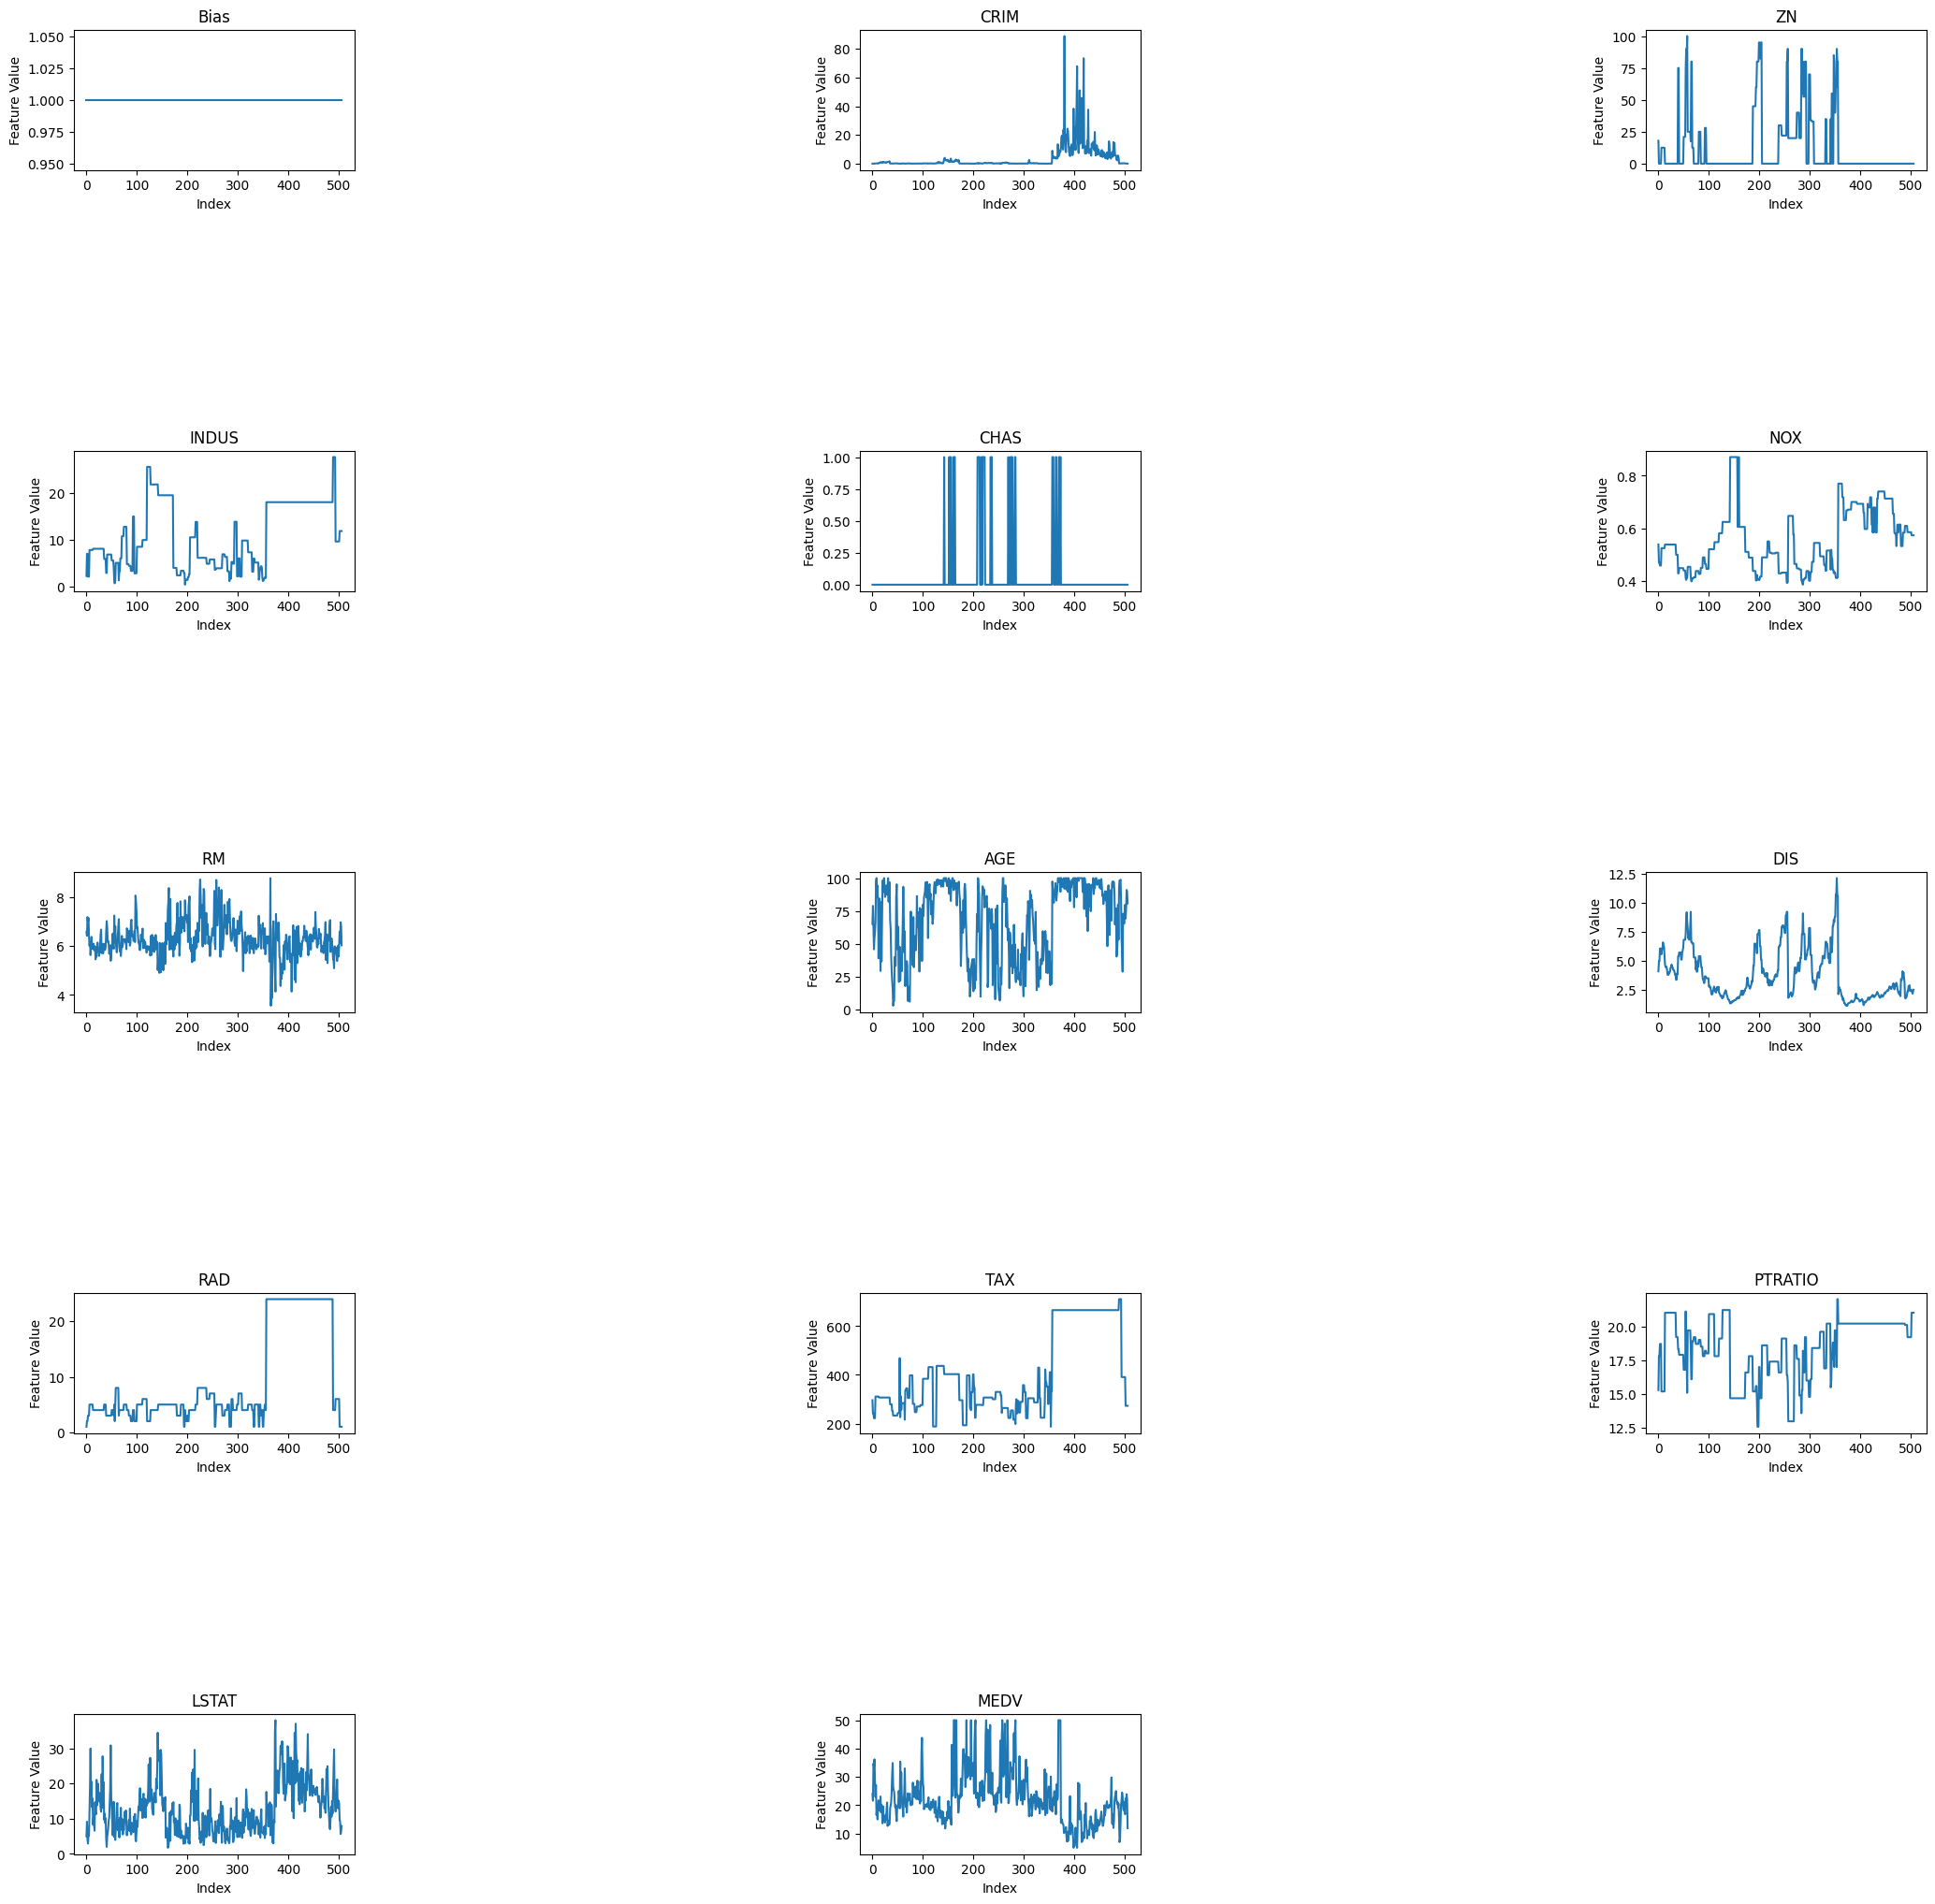

In [26]:
#Task 1 Part 3:
a=[[] for i in range(len(cleaneddb.columns))]

for i in range(len(cleaneddb.columns)):
  arr=[]
  for j in range(len(cleaneddb.index)):
    ele=cleaneddb.iloc[j][i]
    arr.append(ele)
  a[i]=arr

plt.rcParams["figure.figsize"] = [30,30]

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=2)

for i in range(len(a)):
  plt.subplot(6, 6, 2*i+1)
  plt.plot(range(len(cleaneddb.index)), a[i])
  plt.xlabel("Index")
  plt.ylabel("Feature Value")
  feature=str(cleaneddb.columns[i])
  plt.title(feature)

In [3]:
#Part 2, Task 1

class LinReg(object):
  def __init__(self, X, Y, miniBatch=len(X)):
    self.X=X
    self.Y=Y
    self.w=None
    self.miniBatch=miniBatch
    
  def fitlinear(self):
    Xmatrix=self.X
    XT=np.transpose(self.X)
    inv=np.linalg.inv(np.matmul(XT, Xmatrix))
    a=np.matmul(XT, self.Y)
    self.w=np.matmul(inv, a)

  def fitlogistic(self, eps, alpha):
    lr=alpha
    #w=[-1]*len(self.X[0])
    w=[0]*len(self.X[0])
    n=0
    while 1:
        gradient=self.gradient(X, w)
        if np.linalg.norm(gradient)<eps or n>10000:
            break
        for d in range(len(w)):
            #w[d]-=lr*gradient[d]
            w[d]-=lr*gradient[d]
        n+=1
    self.w=w
            
  def gradient(self, X, w):
    gradient=[0]*len(self.X[0]) #D length vector
    indices=randindices(self.X, self.miniBatch)
    batch=self.batch(indices)
    yhat=np.matmul(batch, w)
    y=[self.Y[ele] for ele in indices]
    yhminusy=[yhat[b]-y[b] for b in range(len(y))]
    gradient=(1/self.miniBatch)*np.matmul(np.transpose(batch),yhminusy)
    return gradient

  def batch(self, randindices):
    batch=[self.X[ele] for ele in randindices]
    return batch

  def getMSE(self, Xtest, Ytest):
      Ypredicted=self.predictlinear(Xtest)
      Yhminusy=np.subtract(Ypredicted, Ytest)
      return ((np.linalg.norm(Yhminusy))**2)*(1/2)
      
  def predictlinear(self, X):
    return np.matmul(X, self.w)

In [14]:
class LogReg(object):

    #w=[[w1],[w2],[w3]]
    def __init__(self, X, Y, miniBatch=0):
        self.X=X
        self.Y=Y
        self.miniBatch=miniBatch
        self.numClasses=max(Y)
        self.numFeatures=len(X[0])
        self.w=None
        
    def gradient(self, X, Y, w):
        N=len(Y) #Number of data samples
        gradient=[[0]*self.numFeatures for i in range(self.numClasses)]
        if self.miniBatch==0:
            for c in range(self.numClasses):
                for d in range(self.numFeatures):
                    gradient[c][d]=self.gradientsum(c, d, X, Y, w)
        else:
            indices=randindices(self.X, self.miniBatch)
            batch=self.batch(indices)
            Ybatch=[self.Y[ele] for ele in indices]
            for c in range(self.numClasses):
                for d in range(self.numFeatures):
                    gradient[c][d]=self.gradientsum(c,d, batch, Ybatch, w)
        return gradient
            
    def gradientsum(self, c, d, X, Y, w):
        wvec=w[c]
        ans=0
        for n in range(len(Y)):
            xnd=X[n][d]
            x=X[n]
            zc=[np.dot(w[i], x) for i in range(self.numClasses)]
            maxzc=max(zc)
            zc=[np.exp(zc[i]-maxzc) for i in range(len(zc))]
            logyhat=np.dot(w[c],x)-maxzc-np.log(np.sum(zc))
            yn=1 if Y[n]==c+1 else 0
            ans+=(np.exp(logyhat)-yn)*(xnd)
        return ans 

    def batch(self, randindices):
        batch=[self.X[ele] for ele in randindices]
        return batch
        
    def fit(self, eps, alpha=0, power=1):
        lr=alpha if alpha!=0 else 1
        omega=[[0]*self.numFeatures for i in range(self.numClasses)]
        n=0
        while 1:
            self.w=omega
            n+=1
            gradient=self.gradient(self.X,self.Y,omega) #DxC matrix
            g=[]
            for i in range(len(gradient)):
                g+=gradient[i]
            if np.linalg.norm(g)<eps or n>10000:
                """print(g)
                print(self.w)"""
                break
            for i in range(len(omega)):
                for j in range(len(omega[i])):
                    omega[i][j]-=lr*gradient[i][j]
            lr=1/(n**power+1)
        self.w=omega
        return self.w

    def getLoss(self, Xtest, Ytest):
        if self.w==None:
            return None
        else:
            ans=0
            for c in range(self.numClasses):
                wvec=self.w[c]
                for n in range(len(Ytest)):
                    zc=[np.dot(self.w[i], Xtest[n]) for i in range(self.numClasses)]
                    maxzc=np.max(zc)
                    zc=[zc[i]-maxzc for i in range(len(zc))]
                    yn=1 if Ytest[n]==c+1 else 0
                    ans+=yn*np.dot(self.w[c], Xtest[n])-maxzc-np.sum([np.exp(zc[i]) for i in range(len(zc))])
            return ans/len(Ytest)

    def getMetrics(self, Xtest, Ytest):
        Ypredicted=[self.predict(Xtest[i]) for i in range(len(Xtest))]
        counts=[{"TP": 0, "TN": 0, "FP": 0, "FN": 0} for i in range(self.numClasses)]
        metrics=[{"accuracy": 0, "precision": 0, "recall": 0, "f1": 0} for i in range(self.numClasses)]
        for c in range(self.numClasses):
            for i in range(len(Ypredicted)):
                Yactual=Ytest[i]
                if Ypredicted[i]==Yactual and Yactual==c+1:
                    counts[c-1]["TP"]+=1
                elif Ypredicted[i]==Yactual and Yactual!=c+1:
                    counts[c-1]["TN"]+=1
                elif Ypredicted[i]!=c+1 and Yactual==c+1:
                    counts[c-1]["FN"]+=1
                elif Ypredicted[i]==c+1 and Yactual!=c+1:
                    counts[c-1]["FP"]+=1
        for c in range(self.numClasses):
            TP=counts[c]["TP"]
            TN=counts[c]["TN"]
            FP=counts[c]["FP"]
            FN=counts[c]["FN"]
            P=TP+FN
            N=TN+FP
            RP=TP+FP
            RN=FN+TN
            metrics[c]["accuracy"]=(TP+TN)/(P+N)
            metrics[c]["precision"]=TP/RP
            metrics[c]["recall"]=TP/P
            metrics[c]["f1"]=(metrics[c]["precision"]*metrics[c]["recall"])*2/(metrics[c]["precision"]+metrics[c]["recall"])
        return metrics
        
    def predict(self, x):
        if self.w==None:
            return None
        else:
            prob=0
            ans=0
            for i in range(self.numClasses):
                probc=np.dot(self.w[i],x)
                if probc>prob:
                    ans=i+1
            return ans

In [15]:
#Task 3 Part 1

X=copy.deepcopy(cleaneddbnp)

Y=copy.deepcopy(cleaneddbtargets)

cutoff=int(np.floor(0.8*len(X)))
Xtraining=X[:cutoff]
Xtest=X[cutoff+1:]
Ytraining=Y[:cutoff]
Ytest=Y[cutoff+1:]

linearregression=LinReg(Xtraining,Ytraining, len(Xtraining))
linearregression.fitlinear()

print("Analytical loss is:", linearregression.getMSE(Xtest, Ytest))
      
mblinearregression=LinReg(Xtraining,Ytraining, len(Xtraining))
mblinearregression.fitlogistic(0.01, 0.01)

print("SGD loss is:", mblinearregression.getMSE(Xtest, Ytest))

X=copy.deepcopy(winefeaturesnp)

#Need to transform any new data in the same

Y=copy.deepcopy(winetargets)

cutoff=int(np.floor(0.8*len(X)))
indices=randindices(X, cutoff)
Xtraining=[X[ele] for ele in indices]
Xtest=[X[ele] for ele in range(len(X)) if ele not in indices]
Ytraining=[Y[ele] for ele in indices]
Ytest=[Y[ele] for ele in range(len(Y)) if ele not in indices]

logisticregression=LogReg(Xtraining,Ytraining, 64)
logisticregression.fit(0.01, 0.001)

print("Metrics are:")
logisticregression.getMetrics(Xtest, Ytest)

Analytical loss is: 9.838809950942512e-27
SGD loss is: 0.09599676486445374
Metrics are:


[{'accuracy': 0.8888888888888888,
  'precision': 1.0,
  'recall': 0.7142857142857143,
  'f1': 0.8333333333333333},
 {'accuracy': 0.9411764705882353,
  'precision': 0.8571428571428571,
  'recall': 1.0,
  'f1': 0.923076923076923},
 {'accuracy': 0.9411764705882353,
  'precision': 0.8333333333333334,
  'recall': 1.0,
  'f1': 0.9090909090909091}]

In [53]:
#Task 3 Part 2

def partitionindices(array, Nfold):
    indices = np.arange(len(array))
    np.random.shuffle(indices)

    foldsize=len(array)//Nfold
    partitions=[]

    for i in range(Nfold):
        start=i*foldsize
        end=(i+1)*foldsize if i<Nfold-1 else None
        partitionindices=indices[start:end]
        partitions.append(partitionindices)

    return partitions
    
Nfold=5

partitionedindices=partitionindices(winefeaturesnp, 5)
        
linregerror=0
lingregwsgderror=0

for n in range(Nfold):
    Xtraining=[]
    Ytraining=[]
    for i in range(len(partitionedindices)):
        if i!=n:
            for index in partitionedindices[i]:
                Xtraining.append(cleaneddbnp[index])
                Ytraining.append(cleaneddbtargets[index])
    Xvalidation=[cleaneddbnp[index] for index in partitionedindices[n]]
    Yvalidation=[cleaneddbtargets[index] for index in partitionedindices[n]]
    
    linreg=LinReg(Xtraining,Ytraining)
    linreg.fitlinear()
    linregerror+=linreg.getMSE(Xvalidation, Yvalidation)
    print("Analytic error is:", linreg.getMSE(Xvalidation, Yvalidation))

    linregwsgd=LinReg(Xtraining,Ytraining, 128)
    linregwsgd.fitlogistic(0.01, 0.01)
    lingregwsgderror+=linregwsgd.getMSE(Xvalidation, Yvalidation)
    print("SGD error is:", linregwsgd.getMSE(Xvalidation, Yvalidation))
    
print("Average analytic error is:", linregerror/Nfold)
print("Average SGD error is", lingregwsgderror/Nfold)

#I don't think I can divide equally in this case, since they're all in order of class 1, 2, 3.
partitionedindices=partitionindices(winefeaturesnp, 5)
        
logregerror=0

for n in range(Nfold):
    Xtraining=[]
    Ytraining=[]
    for i in range(len(partitionedindices)):
        if i!=n:
            for index in partitionedindices[i]:
                Xtraining.append(winefeaturesnp[index])
                Ytraining.append(winetargets[index])
    Xvalidation=[winefeaturesnp[index] for index in partitionedindices[n]]
    Yvalidation=[winetargets[index] for index in partitionedindices[n]]

    logreg=LogReg(Xtraining,Ytraining, 32)
    logreg.fit(0.01, 0.01, 1)
    logregerror+=logreg.getLoss(Xvalidation, Yvalidation)
    print("SGD error is:", logreg.getLoss(Xvalidation, Yvalidation))
    print(logreg.getMetrics(Xvalidation, Yvalidation))
    
print("Average SGD error is:", logregerror/Nfold)

Analytic error is: 1.1364247616737883e-25
SGD error is: 0.030799288255444687
Analytic error is: 2.4710743375371164e-25
SGD error is: 0.20489175837813786
Analytic error is: 5.653286936348828e-27
SGD error is: 0.0787767429636341
Analytic error is: 1.2895122490915045e-25
SGD error is: 0.0638688802541914
Analytic error is: 1.1727981095669386e-25
SGD error is: 0.1425694150941173
Average analytic error is: 1.2252684654465672e-25
Average SGD error is 0.10418121698910507
SGD error is: -41.15030091555187
[{'accuracy': 0.9428571428571428, 'precision': 1.0, 'recall': 0.875, 'f1': 0.9333333333333333}, {'accuracy': 0.9428571428571428, 'precision': 0.75, 'recall': 1.0, 'f1': 0.8571428571428571}, {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}]
SGD error is: -39.18723902752493
[{'accuracy': 0.9714285714285714, 'precision': 1.0, 'recall': 0.9411764705882353, 'f1': 0.9696969696969697}, {'accuracy': 0.9714285714285714, 'precision': 0.9, 'recall': 1.0, 'f1': 0.9473684210526316}, {'accuracy'

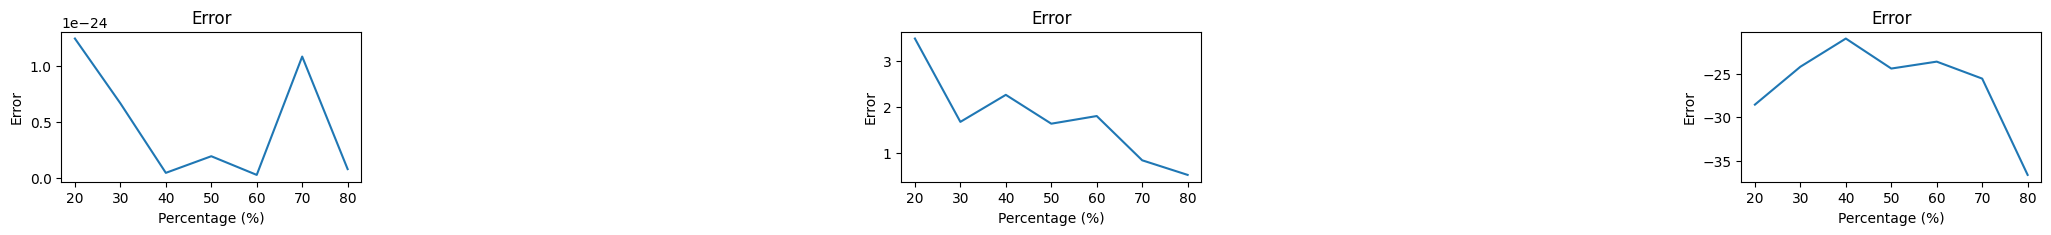

In [23]:
#Task 3 Part 3:
partitionedindices=partitionindices(cleaneddbnp, 10)

linregerror=[]
linregwsgderror=[]
logregerror=[]
errors=[linregerror, linregwsgderror, logregerror]
percentages=[20, 30, 40, 50, 60, 70, 80]
for Nfold in range(2, 9):
    sample=rand.sample(range(len(partitionedindices)), Nfold)
    included=[partitionedindices[i] for i in sample]
    notincluded=[partitionedindices[i] for i in range(len(partitionedindices)) if i not in sample]
    Xtraining=[]
    Ytraining=[]
    Xvalidation=[]
    Yvalidation=[]
    for i in range(len(included)):
        for index in included[i]:
            Xtraining.append(cleaneddbnp[index])
            Ytraining.append(cleaneddbtargets[index])
    for i in range(len(notincluded)):
        for index in notincluded[i]:
            Xvalidation.append(cleaneddbnp[index])
            Yvalidation.append(cleaneddbtargets[index])

    linreg=LinReg(Xtraining,Ytraining)
    linreg.fitlinear()
    linregerror.append(linreg.getMSE(Xvalidation, Yvalidation))

    linregwsgd=LinReg(Xtraining,Ytraining, 16)
    linregwsgd.fitlogistic(0.01, 0.01)
    linregwsgderror.append(linregwsgd.getMSE(Xvalidation, Yvalidation))

partitionedindices=partitionindices(winefeaturesnp, 10)

for Nfold in range(2, 9):
    sample=rand.sample(range(len(partitionedindices)), Nfold)
    included=[partitionedindices[i] for i in sample]
    notincluded=[partitionedindices[i] for i in range(len(partitionedindices)) if i not in sample]
    Xtraining=[]
    Ytraining=[]
    Xvalidation=[]
    Yvalidation=[]
    for i in range(len(included)):
        for index in included[i]:
            Xtraining.append(winefeaturesnp[index])
            Ytraining.append(winetargets[index])
    for i in range(len(notincluded)):
        for index in notincluded[i]:
            Xvalidation.append(winefeaturesnp[index])
            Yvalidation.append(winetargets[index])

    logreg=LogReg(Xtraining,Ytraining, 16)
    logreg.fit(0.01, 0.01)
    logregerror.append(logreg.getLoss(Xvalidation,Yvalidation))

plt.rcParams["figure.figsize"] = [30,30]

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=2)

for i in range(len(errors)):
  plt.subplot(6, 6, 2*i+1)
  plt.plot(percentages, errors[i])
  plt.xlabel("Percentage (%)")
  plt.ylabel("Error")
  plt.title("Error")    

In [37]:
#Task 3 Part 4:

X=copy.deepcopy(cleaneddbnp)
Y=copy.deepcopy(cleaneddbtargets)
for pow in range(1,8):
    linregwsgd=LinReg(X, Y, 2**pow)
    starttime=time.time()
    linregwsgd.fitlogistic(0.01, 0.01)
    print("Execution time for batch size %d with linear regression is: %f seconds" % (2**pow, time.time()-starttime))
    print("Error is %f" % linregwsgd.getMSE(X,Y))
    
X=winefeaturesnp
Y=winetargets

for pow in range(1,8):
    logreg=LogReg(X, Y, 2**pow)
    starttime=time.time()
    logreg.fit(0.01, 0.01)
    print("Execution time for batch size %d with logistic regression is: %f seconds" % (2**pow, time.time()-starttime))
    print("Error is %f" % logreg.getLoss(X,Y))
        

Execution time for batch size 2 is: 0.004456 seconds
Error is 10.256692
Execution time for batch size 4 is: 0.064090 seconds
Error is 3.981356
Execution time for batch size 8 is: 0.113520 seconds
Error is 2.852510
Execution time for batch size 16 is: 0.286106 seconds
Error is 2.167106
Execution time for batch size 32 is: 0.376666 seconds
Error is 1.864200
Execution time for batch size 64 is: 0.407031 seconds
Error is 2.392234
Execution time for batch size 128 is: 1.444599 seconds
Error is 1.744839
Execution time for batch size 2 is: 0.283534 seconds
Error is -9.508675
Execution time for batch size 4 is: 3.203310 seconds
Error is -11.840120
Execution time for batch size 8 is: 0.314165 seconds
Error is -17.640810
Execution time for batch size 16 is: 1.264409 seconds
Error is -27.260938
Execution time for batch size 32 is: 1.955560 seconds
Error is -36.808310
Execution time for batch size 64 is: 3.331941 seconds
Error is -38.645143
Execution time for batch size 128 is: 34.278329 seconds
E

In [47]:
#Task 3 Part 5:

X=copy.deepcopy(cleaneddbnp)
Y=copy.deepcopy(cleaneddbtargets)
for pow in range(-2, -5, -1):
    linregwsgd=LinReg(X, Y)
    starttime=time.time()
    alpha=10**pow
    linregwsgd.fitlogistic(0.01, alpha)
    print("Execution time for learning rate %f with linear regression is: %f seconds" % (alpha, time.time()-starttime))
    print("Error is %f" % linregwsgd.getMSE(X,Y))
    
X=copy.deepcopy(winefeaturesnp)
Y=copy.deepcopy(winetargets)

for pow in range(-2,-5, -1):
    logreg=LogReg(X, Y, 64)
    starttime=time.time()
    alpha=10**pow
    logreg.fit(0.01, alpha)
    print("Execution time for batch size %f with logistic regression is: %f seconds" % (alpha, time.time()-starttime))
    print("Error is %f" % logreg.getLoss(X,Y))
        


Execution time for learning rate 0.010000 with linear regression is: 6.759973 seconds
Error is 1.088375
Execution time for learning rate 0.001000 with linear regression is: 22.342876 seconds
Error is 2.381875
Execution time for learning rate 0.000100 with linear regression is: 23.766651 seconds
Error is 8.576599
Execution time for batch size 0.010000 with logistic regression is: 11.254970 seconds
Error is -34.815181
Execution time for batch size 0.001000 with logistic regression is: 6.848437 seconds
Error is -102.186643
Execution time for batch size 0.000100 with logistic regression is: 3.073401 seconds
Error is -113.912821


In [61]:
#Task 3 Part 6:

"""For linear regression, the analytical solution has no real optimal paramters, since it's analytical by nature. For the logistic regression,
I'm going to take a mix of eps and the alpha, and I'm going to choose the loss function, (MSE) as our parameter. I'm choosing this 
because our analytical solution gives a loss function of around e-27, which is exactly what you would expect for the analytical solution. As such, 
I'm going to choose the parameters that gets me closest to the smallest loss function."""

X=copy.deepcopy(cleaneddbnp)
Y=copy.deepcopy(cleaneddbtargets)
optimalparameters=None
minloss=float('inf')
for epspow in range(-1, -4, -1):
    for lrpow in range(-1, -4, -1):

        linregwsgd=LinReg(X, Y)
        eps=10**epspow
        alpha=10**lrpow
        linregwsgd.fitlogistic(eps, alpha)
        error=linregwsgd.getMSE(X,Y)
        if error<minloss:
            minloss=error
            optimalparameters=[10**epspow, 10**lrpow]
        print("Error for eps of %f, with learning rate of %f, is %f" % (10**epspow, 10**lrpow, error))
        
print("Optimal parameters are an epsilon of %f and a learning rate of %f" %(optimalparameters[0], optimalparameters[1]))        

"""For the logistic regression, the two important things are the batch size, since too large of a batch size will make it not converge, and decay rate 
of learning rate, since it also won't converge if this isn't tuned properly. For the performance metric, we're going to take the recall of each class, 
since for a softmax classification, we really want to know that if we PREDICT something to be of class c, what is the the probability that it 
actually IS of class C, and we'll be taking the average recall across the different classes. """

X=copy.deepcopy(winefeaturesnp)
Y=copy.deepcopy(winetargets)
optimalparameters=None
maxrecall=0
for batchpow in range(1,7):
    for lrpow in range(1,3):
        logreg=LogReg(X, Y, 2**batchpow)
        logreg.fit(0.01, 0.01, lrpow)
        print("Error for batch size of %d, with alpha decay rate of 1/(n**%d+1), is %f" % (2**batchpow, lrpow, logreg.getLoss(X,Y)))
        averagerecall=0
        for metricdict in logreg.getMetrics(X,Y):
            numClasses=logreg.numClasses
            averagerecall+=metricdict["recall"]/numClasses
        if averagerecall>maxrecall:
            maxrecall=averagerecall
            optimalparameters=[2**batchpow, lrpow]
        print("Average recall for batch size of %d, with alpha decay rate of 1/(n**%d+1), is %f" % (2**batchpow, lrpow, averagerecall))
        
print("Optimal parameters are a batch size of %d, and an alpha decay rate of %d" % (optimalparameters[0], optimalparameters[1])

Error for eps of 0.100000, with learning rate of 0.100000, is 10.147803
Error for eps of 0.100000, with learning rate of 0.010000, is 9.876651
Error for eps of 0.100000, with learning rate of 0.001000, is 9.847765
Error for eps of 0.010000, with learning rate of 0.100000, is 1.086527
Error for eps of 0.010000, with learning rate of 0.010000, is 1.088375
Error for eps of 0.010000, with learning rate of 0.001000, is 2.381875
Error for eps of 0.001000, with learning rate of 0.100000, is 0.055097
Error for eps of 0.001000, with learning rate of 0.010000, is 0.181479
Error for eps of 0.001000, with learning rate of 0.001000, is 2.381875
Optimal parameters are an epsilon of 0.001000 and a learning rate of 0.100000


'X=winefeaturesnp\nY=winetargets\nfor batchpow in range(1,7):\n    for lrpow in range(1,3):\n        logreg=LogReg(X, Y, 2**batchpow)\n        logreg.fit(0.01, 0.01, lrpow)\n        print("Error for batch size of %d, with alpha decay rate of 1/(n**%d+1), is %f" % (2**batchpow, lrpow, logreg.getLoss(X,Y)))\n        averagerecall=0\n        for metricdict in logreg.getMetrics(X,Y):\n            numClasses=logreg.numClasses\n            averagerecall+=metricdict["recall"]/numClasses\n        print("Average recall for batch size of %d, with alpha decay rate of 1/(n**%d+1), is %f" % (2**batchpow, lrpow, averagerecall))'

In [19]:
#Task 3 Part 7 

#Using the first half to train, and the second half to test.

def gaussian(x, mu):
    return np.exp(-((x-mu)**2)/2)
    
X=copy.deepcopy(cleaneddb.to_numpy())
Y=copy.deepcopy(bostondb["MEDV"].to_numpy())
numGaussians=5

for columnnum in range(len(X[0])-numGaussians, len(X[0])):
    averagex=np.average(column(X, columnnum))
    for n in range(len(X)):
        X[n][columnnum]=gaussian(X[n][columnnum], averagex)


linreg=LinReg(X,Y)
linreg.fitlinear()
predictedYwgaussian=linreg.predictlinear(X)
print(linreg.getMSE(X,Y))

"""X=copy.deepcopy(cleaneddbnp)
Y=copy.deepcopy(cleaneddbtargets)

linreg=LinReg(X[:len(X)//2], Y[:len(X)//2])
linreg.fitlinear()
predictedYwogaussian=linreg.predictlinear(X[len(X)//2:])

difference=[predictedYwgaussian[i]-predictedYwogaussian[i] for i in range(len(predictedYwgaussian))]
print(difference)
print("Average difference between gaussian and no gaussian is %f", np.average(difference))"""

7803.247403038759


'X=copy.deepcopy(cleaneddbnp)\nY=copy.deepcopy(cleaneddbtargets)\n\nlinreg=LinReg(X[:len(X)//2], Y[:len(X)//2])\nlinreg.fitlinear()\npredictedYwogaussian=linreg.predictlinear(X[len(X)//2:])\n\ndifference=[predictedYwgaussian[i]-predictedYwogaussian[i] for i in range(len(predictedYwgaussian))]\nprint(difference)\nprint("Average difference between gaussian and no gaussian is %f", np.average(difference))'

In [6]:
#Task 3 Part 8:
X=copy.deepcopy(cleaneddbnp)
Y=copy.deepcopy(cleaneddbtargets)

analyticallinreg=LinReg(X,Y)
analyticallinreg.fitlinear()
print(analyticallinreg.getMSE(X,Y))

X=copy.deepcopy(cleaneddbnp)
Y=copy.deepcopy(cleaneddbtargets)

mblinreg=LinReg(X,Y, 64)
mblinreg.fitlogistic(0.01, 0.1)
print(mblinreg.getMSE(X,Y))

"""We see the error on the SGD gradient descent linear regression has much higher error, so it is not preferable over the analytical 
solution in this case. However, since the time complexity for analytical regression is higher than SGD, as the size of the input database
increases, we will see that SGD becomes preferable over the analytical solution due to the runtime of the algorithm."""

1.9341805993800416e-26
1.559461118920303
